In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob


os.chdir("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/gw_edmft/AuBDA14CH2")

In [2]:
base_dir = "Francesco_data"

# Find all site folders and sort them
site_dirs = sorted(glob(os.path.join(base_dir, "MaxEnt_Gdig_*_s1")))

n_sites = len(site_dirs)
# Read self-energy data
energies = None
sigma_real = []
sigma_imag = []

for d in site_dirs:
    # Find the Sdig file
    fname = glob(os.path.join(d, "Sdig*_s1.DAT_dos.dat"))[0]
    data = np.loadtxt(fname)

    E = data[:, 0]
    Re = data[:, 1]
    Im = data[:, 2]

    if energies is None:
        energies = E
    else:
        # Sanity check: energies must match
        if not np.allclose(energies, E):
            raise ValueError(f"Energy grid mismatch in {fname}")

    sigma_real.append(Re)
    sigma_imag.append(Im)

sigma_real = np.array(sigma_real)  # shape (n_sites, nE)
sigma_imag = np.array(sigma_imag)  # shape (n_sites, nE)

# Build self-energy matrices: one 8x8 matrix per energy
# Resulting shape: (nE, 8, 8)
sigma_matrices = np.zeros(
    (len(energies), n_sites, n_sites), dtype=np.complex128
)

for iE in range(len(energies)):
    diag = sigma_real[:, iE] + 1j * sigma_imag[:, iE]
    sigma_matrices[iE] = np.diag(diag)


In [ ]:
# Load rotation matrix
U = np.loadtxt(f"{base_dir}/ReHrot.DAT")

U_dag = U.conj().T

# Rotate self-energy at each energy
# sigma_matrices has shape (nE, 8, 8)
sigma_rot = np.empty_like(sigma_matrices)

for iE in range(len(energies)):
    sigma_rot[iE] = U @ sigma_matrices[iE] @ U_dag

outputdir = "output/lowdin/gw_edmft"
os.makedirs(outputdir, exist_ok=True)
np.save(f"{outputdir}/self_energy_no_dcc.npy", sigma_rot)
np.save(f"{outputdir}/energies.npy", energies)


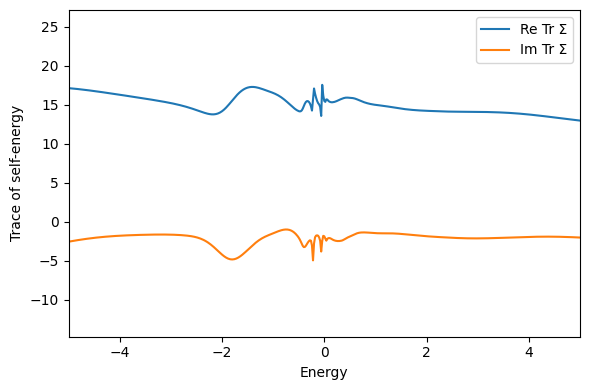

In [4]:
sigma_trace = np.trace(sigma_rot, axis1=1, axis2=2)

trace_real = sigma_trace.real
trace_imag = sigma_trace.imag

plt.figure(figsize=(6, 4))

plt.plot(energies, trace_real, label="Re Tr Σ")
plt.plot(energies, trace_imag, label="Im Tr Σ")

plt.xlim(-5,5)
plt.xlabel("Energy")
plt.ylabel("Trace of self-energy")
plt.legend()
plt.tight_layout()
plt.show()